# Various imports

## Visualization and data manipulation tools

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

## Pipeline creation and preprocessing tools

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, PolynomialFeatures

## MLFlow

In [6]:
import mlflow
# import mlflow.sklearn
from urllib.parse import urlparse

mlflow.get_tracking_uri()

'file:///home/romains/Documents/VSCode/lin_reg/mlruns'

## Other tools and model

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression

# Import and split data

In [8]:
df = pd.read_csv("kc_house_data_clean.csv")

X = df.drop("price", axis=1)
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

X_test.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Pipeline

In [9]:
log_pipeline = make_pipeline(
    SimpleImputer(), FunctionTransformer(np.log), PolynomialFeatures(degree=3), StandardScaler()
)
zipcode_pipeline = make_pipeline(SimpleImputer(), OneHotEncoder())

other_pipeline = make_pipeline(SimpleImputer(), PolynomialFeatures(degree=2), StandardScaler()
)


log_features = ["sqft_living", "sqft_lot", "sqft_above"]#, "sqft_living15", "sqft_lot15"]
other_features = X_train.drop(np.append(log_features, ["zipcode", "sqft_living15", "sqft_lot15"]), axis=1).columns # we may want to remove lat and long

preprocessor = make_column_transformer(
    (log_pipeline, log_features),
    (zipcode_pipeline, ["zipcode"]),
    (other_pipeline, other_features)
)

# Metrics

In [10]:
def eval_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    r2 = r2_score(actual, pred)
    return mae, np.sqrt(mse), r2

# Model

In [11]:
mlflow.sklearn.autolog()
with mlflow.start_run(experiment_id=0):

    model = make_pipeline(preprocessor, LinearRegression())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae, rmse, r2 = eval_metrics(y_test, y_pred)
    print(f"MAE: {mae}\nRMSE: {rmse}\nR2: {r2}")

    mlflow.log_metric("mae_test", mae)
    mlflow.log_metric("rmse_test", rmse)
    mlflow.log_metric("r2_test", r2)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    print(tracking_url_type_store)

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(
            model, "model", registered_model_name="linear_regression"
        )
    else:
        mlflow.sklearn.log_model(model, "model")

2022/03/03 14:52:59 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                          ...`
2022/03/03 14:52:59 WARNING mlflow.utils: Truncated the value of the key `columntransformer`. Truncated value: `ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('functiontransf...`
2022/03/03 14:53:00 WARNING mlflow.utils: Truncated the value of the key `columntransformer__transformers`. Truncated value: `[('pipeline-1', Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('functiontransformer',
                 FunctionTransformer(func=<ufunc '

MAE: 78057.81941931804
RMSE: 132836.43207479714
R2: 0.8671348274819021
file


In [9]:
model = make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrics = eval_metrics(y_test, y_pred)
print(f"MAE: {metrics[0]}\nRMSE: {metrics[1]}\nR2: {metrics[2]}")

MAE: 80137.96402239491
RMSE: 137369.68121194054
R2: 0.8579116299583217


In [469]:
param_grid = {'columntransformer__pipeline-1__polynomialfeatures__degree': np.arange(4), 'columntransformer__pipeline-3__polynomialfeatures__degree': np.arange(4)}

grid = GridSearchCV(model, param_grid=param_grid, cv=5)

In [470]:
grid.fit(X_train, y_train)

# Pipeline(steps=[('columntransformer',
#                  ColumnTransformer(transformers=[('pipeline-1',
#                                                   Pipeline(steps=[('simpleimputer',
#                                                                    SimpleImputer()),
#                                                                   ('functiontransformer',
#                                                                    FunctionTransformer(func=<ufunc 'log'>)),
#                                                                   ('polynomialfeatures',
#                                                                    PolynomialFeatures()),
#                                                                   ('standardscaler',
#                                                                    StandardScaler())]),
#                                                   ['sqft_living', 'sqft_lot',
#                                                    'sqft_above',
#                                                    'sqft_living15',
#                                                    'sqft_lot15']),
#                                                  ('...
#                                                                   ('onehotencoder',
#                                                                    OneHotEncoder())]),
#                                                   ['zipcode']),
#                                                  ('pipeline-3',
#                                                   Pipeline(steps=[('simpleimputer',
#                                                                    SimpleImputer()),
#                                                                   ('polynomialfeatures',
#                                                                    PolynomialFeatures()),
#                                                                   ('standardscaler',
#                                                                    StandardScaler())]),
#                                                   Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
#        'grade', 'yr_built', 'yr_renovated'],
#       dtype='object'))])),
#                  ('linearregression', LinearRegression())]

/Users/rom1/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


35 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rom1/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rom1/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/rom1/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(func=<ufunc 'log'>)),
                                                                                         ('polynomialfeatures',
                                                                                          PolynomialFeatures(degree=3)),
                                                                                         ('standardscaler',
                                

In [12]:
import shap
shap.initjs()

In [13]:
X100 = shap.utils.sample(X, 100)

In [15]:
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

Permutation explainer: 21594it [1:43:48,  3.46it/s]                           


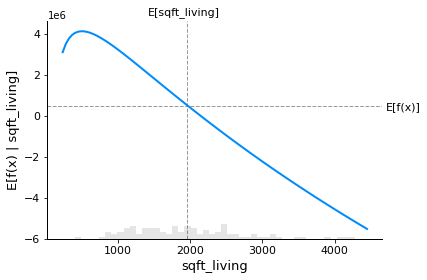

In [36]:
sample_ind=18
shap.plots.partial_dependence(
  "sqft_living", model.predict, X100, ice=False,
  model_expected_value=True, feature_expected_value=True,
  shap_values=shap_values[sample_ind:sample_ind+1,:]
)

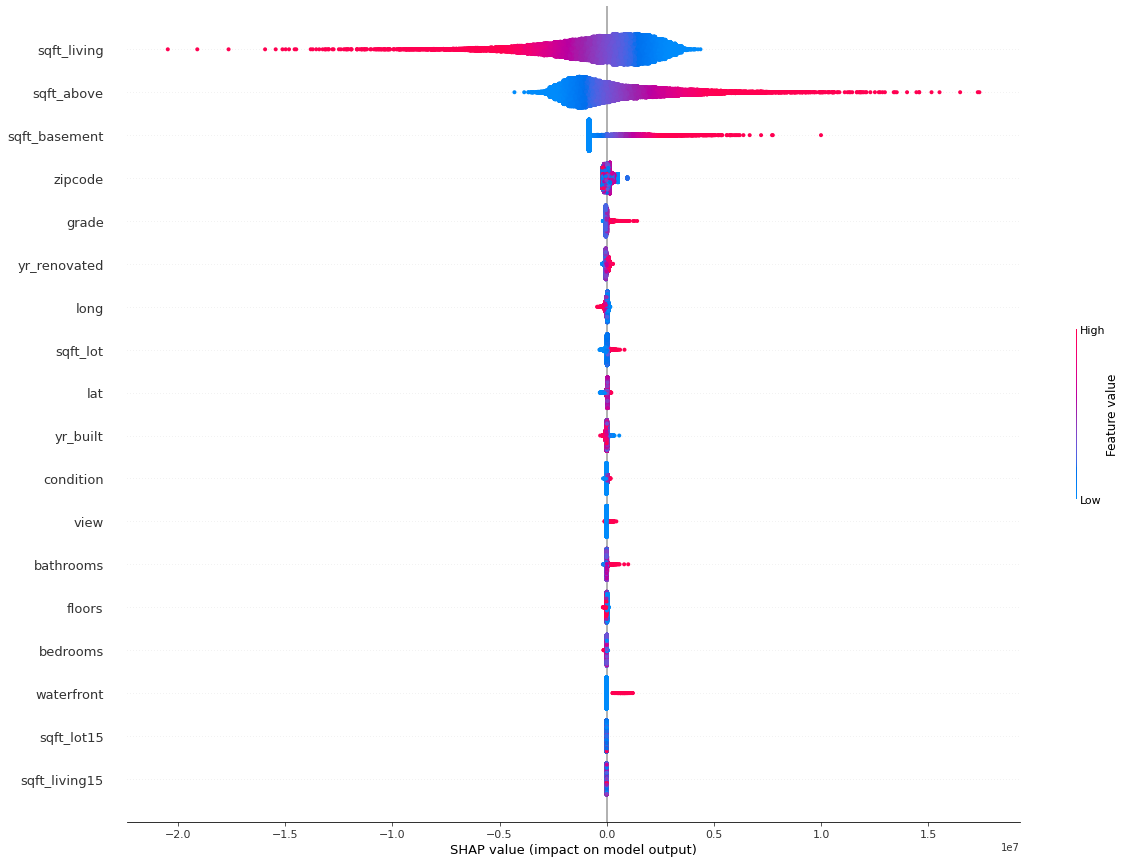

In [20]:
shap.summary_plot(
    shap_values,
    X,
    plot_size=(20,15),
)

In [472]:
print(grid.best_params_)
grid.score(X_test, y_test)

{'columntransformer__pipeline-1__polynomialfeatures__degree': 3, 'columntransformer__pipeline-3__polynomialfeatures__degree': 2}


0.8492012500435684

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

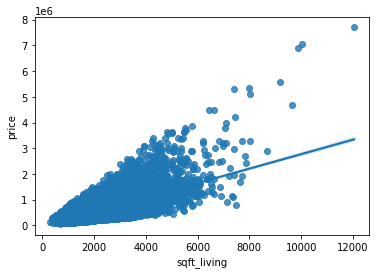

In [473]:
sns.regplot(x="sqft_living", y="price", data=df)

Text(0.5, 0, 'Actual price')

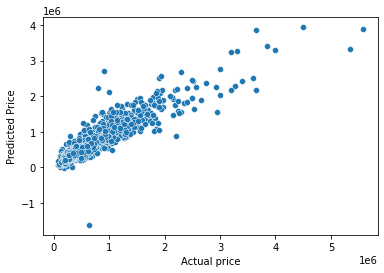

In [474]:
sns.scatterplot(x=y_test, y=y_pred)
plt.ylabel("Predicted Price")
plt.xlabel("Actual price")

<AxesSubplot:xlabel='price'>

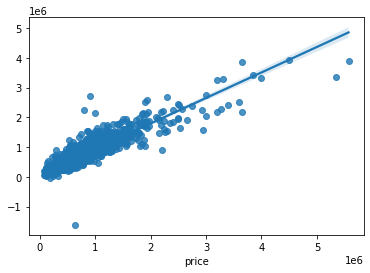

In [475]:
sns.regplot(x=y_test, y=y_pred)

In [476]:
from sklearn.manifold import TSNE

In [477]:
tsne = TSNE(2)
preprocessor_result = preprocessor.fit_transform(X_train)
tsne_result = tsne.fit_transform(preprocessor_result)

/Users/rom1/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/rom1/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [478]:
tsne_result.shape

(17289, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


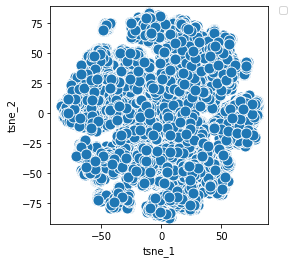

In [479]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1]})#, 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)